In [32]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
from matplotlib.patches import Patch

# statsmodels and sklearn are currently not used. Both packages can be omitted for now, but sklearn will
# very likely be used in the future

%matplotlib inline
#sns.set_theme(font="Arial")
# Folder containing the data file
#data_dir = r'F:\Andrew Markel\Ultrasound Data' # For UITC 2023 talk
data_dir = r'D:\Andrew\Prolapse Model'  # For UITC 2023 talk

# Name of the file containing the QUS results
#data_fid = r'2023-03-07_GD14-18.csv'
data_fid = r'2025-07-09-first-frame.csv'
key_fid = r'anatomy_qus.csv'

# Define an array of the QUS parameter names. This will be useful later
qus_params = ['ESD','EAC','MBF','SS','I0','Naka Omega','Naka m','HK k','HK alpha']
qus_params_key = ['ESD ($\mu$m)','EAC (dB/m$^{3}$)','MBF (dB/sr/m)','SS (dB/sr/m/MHz)','I0 (dB/sr/m)','Naka $\Omega$ (kV$^{2}$)','Naka m (a.u.)','HK $\kappa$ (a.u.)','HK $\\alpha$ (a.u.)']

# Move to the data folder and read the .csv into a DataFrame
os.chdir(data_dir)
all_data = pd.read_csv(data_fid)
key_data = pd.read_csv(key_fid)

original_names = ['HKStructureParam','HKScattererClusteringParam','NakShapeParam','NakScaleFactor', 
             'SpectralSlope','Intercept','MidbandFit','EffectiveScattererSize','AcousticConcentration']


# Rename the columns using abbreviations for the parameter names
new_names = {'HKStructureParam':'HK k','HKScattererClusteringParam':'HK alpha','NakShapeParam':'Naka m','NakScaleFactor':'Naka Omega', 
             'SpectralSlope':'SS','Intercept':'I0','MidbandFit':'MBF','EffectiveScattererSize':'ESD','AcousticConcentration':'EAC'}

# Convert ESD from m to um
all_data['AcousticConcentration'] *= 1e6
all_data['NakScaleFactor'] /= 1e6

# Log compress the Nakagami Omega and HK alpha parameters
#all_data['Naka Omega'] = np.log10(all_data['Naka Omega'])
#all_data['HK alpha'] = np.log10(all_data['HK alpha'])

# As a precaution, remove any rows that contain a NaN in any column
all_data.dropna(axis=0,inplace=True)

all_data_copy = all_data.copy()

# Based on the ID string, split into new columns with ID, Day, and Frame #
#all_data[['ID','Day','Frame']] = all_data['ID'].str.split('_',2,expand=True)

# Convert Day column into integer data type (instead of string)
#all_data['Day'] = all_data['Day'].astype(int)

# # Keep only the first 5 characters from the ID - the last specifies placenta (not animal) and is not needed at this time
# # This will make it easier to separate the Normal and treat groups
# all_data['ID'] = all_data['ID'].str[:5]

# Remove any rows where the ESD is zero 
# This means QUS estimation failed
remove_idx = (all_data['AcousticConcentration'] <= 0)
all_data.drop(all_data.loc[remove_idx].index,inplace=True)

#sum_data = all_data.groupby(['ID'],as_index=False).count()

# Group by animal
#all_data.loc[:,'Animal'] = all_data['ID'].str[:5]

# #Specify placentas which do not meet the criteria for inclusion in this study
#drop_placentas = {'N6_C4_FM','N6_F2','N8_C1_M','P1_C2_M','P2_C1_F','P2_C1_M','P2_C2_F','P2_C2_M','P2_C3_F','P2_C3_M','P2_C4_F','P2_C4_M','P2_C5_F','P2_C5_M','P2_C6_F','P2_C6_M'}

#for drop_p in drop_placentas:
#    all_data.drop(all_data.loc[all_data['ID'] == drop_p].index,inplace=True)

# Based on the ID string, split into new columns with ID, Day, and Frame #
#all_data[['ID','Cotyledon','Side']] = all_data['ID'].str.split('_',2,expand=True)

#Group by animal
#all_data.loc[:,'Type'] = all_data['ID'].str[0:1]
#all_data['Distance'] = all_data['Distance']*100
#all_data['Distance'] = all_data['Distance'].astype(int)
#all_data['Distance'] = all_data['Distance'].astype(str)
#all_data

rp = [(230,171,36),(0,158,115),(173,111,214)]
rp = list(tuple(ti/256 for ti in t) for t in rp)

#in_data = all_data[all_data['Side'] == 'F']
ids = key_data.ID

for i in ids:
    i_str = 'M' + str(i) 
    g = key_data[key_data['ID'] == i]['Grade'].values
    print(g)

    if g > 0:
        all_data.loc[all_data['ID'] == i_str,'Type'] = 'Prolapsed'
    else:
        all_data.loc[all_data['ID'] == i_str,'Type'] = 'Normal'


all_data.loc[all_data['Organ'] == 'vagina','Organ'] = 'Vagina'
all_data.loc[all_data['Organ'] == 'external','Organ'] = 'ExternalOs'
all_data.loc[all_data['Organ'] == 'internal','Organ'] = 'InternalOs'
all_data.loc[all_data['Organ'] == 'uterus','Organ'] = 'Uterus'

in_data = all_data.groupby(['ID','Organ','Type'],as_index = False).mean()

for q_idx, param in enumerate(original_names):
    #Anova analysis
    model = ols(param + ' ~ C(Type) + C(Organ) + C(Type):C(Organ)', data = in_data).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(param)
    print(result)

in_data.rename(new_names,axis=1,inplace=True)

all_regions = ["Vagina","ExternalOs","InternalOs","Uterus"]
in_data['Organ'] = pd.Categorical(in_data['Organ'], categories = all_regions, ordered = True)

all_types = ["Normal","Prolapsed"]
in_data['Type'] = pd.Categorical(in_data['Type'], categories = all_types, ordered = True)

#in_data

[0]
[0]
[0]
[0]
[0]
[2]
[0]
[2]
[0]
[0]
[0]
[0]
[3]
[2]
[2]
HKStructureParam
                    df    sum_sq   mean_sq         F    PR(>F)
C(Type)            1.0  0.005899  0.005899  5.168724  0.027155
C(Organ)           3.0  0.001780  0.000593  0.519766  0.670552
C(Type):C(Organ)   3.0  0.002369  0.000790  0.691916  0.561123
Residual          52.0  0.059350  0.001141       NaN       NaN
HKScattererClusteringParam
                    df      sum_sq    mean_sq         F    PR(>F)
C(Type)            1.0   22.900533  22.900533  6.436974  0.014216
C(Organ)           3.0    5.349139   1.783046  0.501186  0.683116
C(Type):C(Organ)   3.0   13.291238   4.430413  1.245318  0.302799
Residual          52.0  184.998078   3.557655       NaN       NaN
NakShapeParam
                    df    sum_sq   mean_sq          F    PR(>F)
C(Type)            1.0  0.076968  0.076968  10.811785  0.001813
C(Organ)           3.0  0.009800  0.003267   0.458890  0.712183
C(Type):C(Organ)   3.0  0.015769  0.005256   

In [3]:
p_mat = np.zeros((len(qus_params),len(all_regions)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, dist in enumerate(all_regions):
    #dist = str(round(dist,1))
    #print(in_data['ESD'])
    sub_df = in_data[in_data['Organ'] == dist]
    #print(sub_df)

    for q_idx, param in enumerate(qus_params):
        var_c = sub_df[sub_df['Type'] == 'Normal'][param]
        var_r = sub_df[sub_df['Type'] == 'Prolapsed'][param]

        #print(var_c)
        #print(var_r)

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        #print(this_p)
        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df_dist = pd.DataFrame(p_mat,index=qus_params,columns=all_regions)
diff_df_dist = pd.DataFrame(diff_mat,index=qus_params,columns=all_regions)

p_df_dist

C:\Users\amarkel\AppData\Local\Temp\ipykernel_5852\3342584826.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat[q_idx,d_idx] = this_p


,Vagina,ExternalOs,InternalOs,Uterus
ESD,0.354964,0.338903,0.319474,0.320660
EAC,0.979899,0.740407,0.776378,0.449954
MBF,0.752913,0.638928,0.795915,0.444494
SS,0.399612,0.273414,0.282988,0.282101
I0,0.233076,0.114013,0.430940,0.774595
Naka Omega,0.148979,0.496872,0.723689,0.224285
Naka m,0.145249,0.002365,0.218305,0.489663
HK k,0.071263,0.000228,0.541362,0.937302
HK alpha,0.152736,0.000930,0.557169,0.890831


In [4]:
#Procedurally generate comparison pairs
comp_pairs = [None]*len(all_regions)
print(comp_pairs)

for d_idx, dist in enumerate(all_regions):
    comp_pairs[d_idx] = [(dist,'Normal'),(dist,'Prolapsed')]

print(comp_pairs)

[None, None, None, None]
[[('Vagina', 'Normal'), ('Vagina', 'Prolapsed')], [('ExternalOs', 'Normal'), ('ExternalOs', 'Prolapsed')], [('InternalOs', 'Normal'), ('InternalOs', 'Prolapsed')], [('Uterus', 'Normal'), ('Uterus', 'Prolapsed')]]


[0.3549641956501979, 0.33890274869799564, 0.31947430572557883, 0.3206599238668214]


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:3.389e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:3.550e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:3.195e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:3.207e-01
[0.97989933897303, 0.7404068556434609, 0.7763784100033884, 0.4499542737041612]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:7.404e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:9.799e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:7.764e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:4.500e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


[0.752913470560341, 0.6389282107925047, 0.7959153545064495, 0.44449408912842747]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:6.389e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:7.529e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:7.959e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:4.445e-01
[0.399611916453945, 0.27341379388309844, 0.28298825361085955, 0.2821011017304011]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:2.734e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:3.996e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:2.830e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:2.821e-01
[0.23307566737871613, 0.1140125954569034, 0.43093986286513, 0.7745952305898973]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:1.140e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:2.331e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:4.309e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:7.746e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


[0.14897897996047274, 0.49687179445118657, 0.7236885273742049, 0.22428475406110399]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:4.969e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:1.490e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:7.237e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:2.243e-01
[0.14524901069465182, 0.002365259402945162, 0.2183047160395497, 0.48966326859875664]


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\ama

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:2.365e-03
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:1.452e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:2.183e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:4.897e-01
[0.07126297874777676, 0.00022822879840892228, 0.5413617368073517, 0.9373019823437174]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:2.282e-04
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:7.126e-02
InternalOs_Normal vs. InternalOs_Prolapsed: 

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\ama

[0.1527364104335072, 0.0009300238981963822, 0.557169285986957, 0.8908306210565976]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:9.300e-04
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:1.527e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:5.572e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:8.908e-01


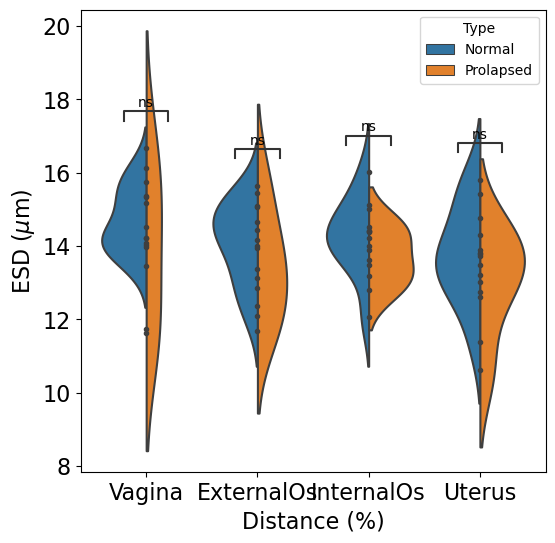

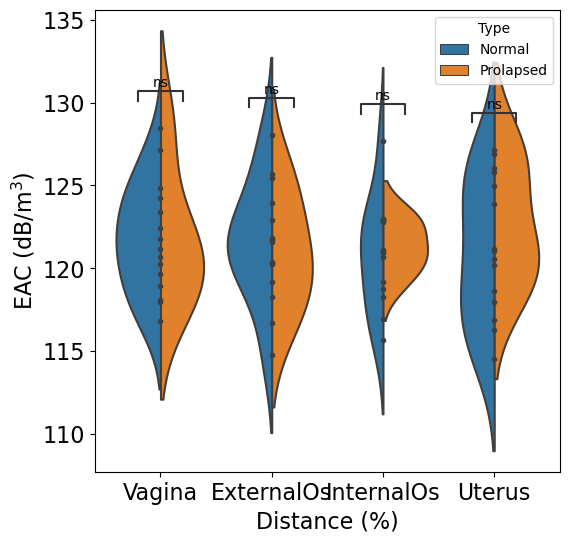

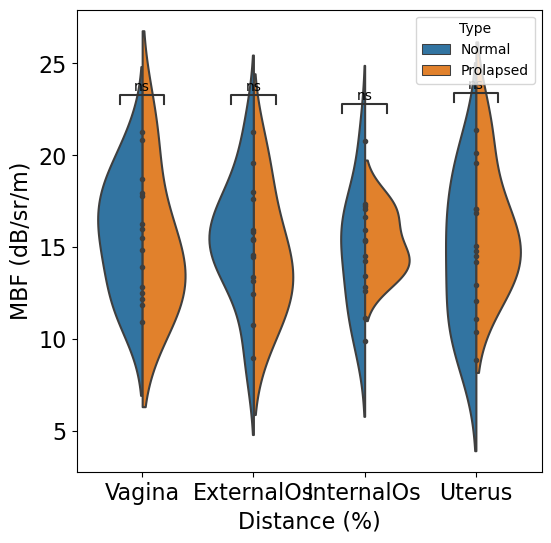

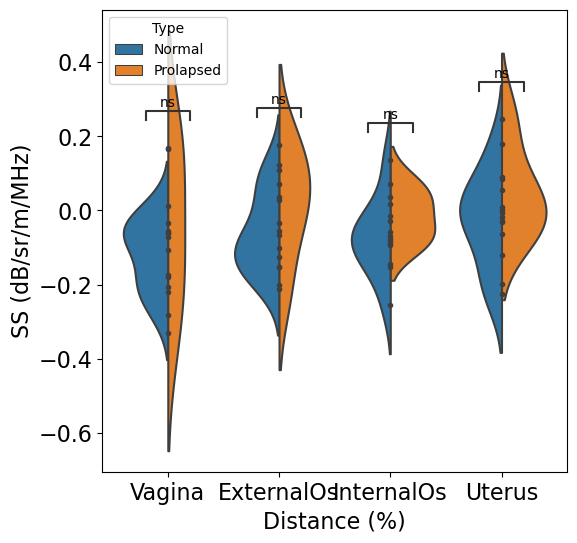

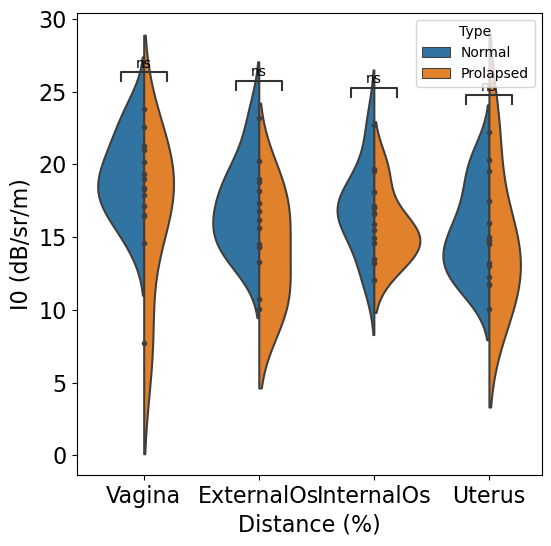

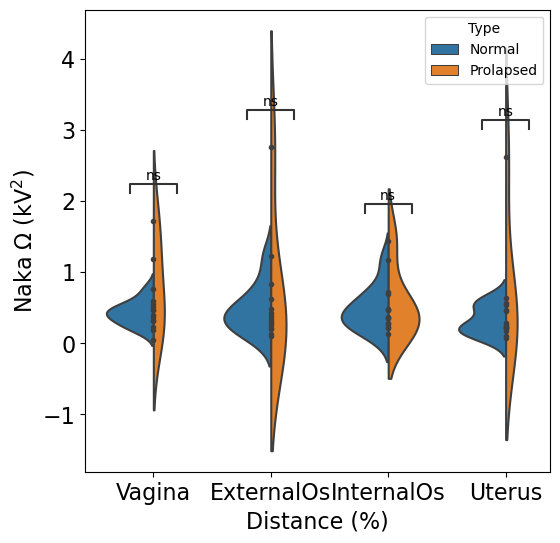

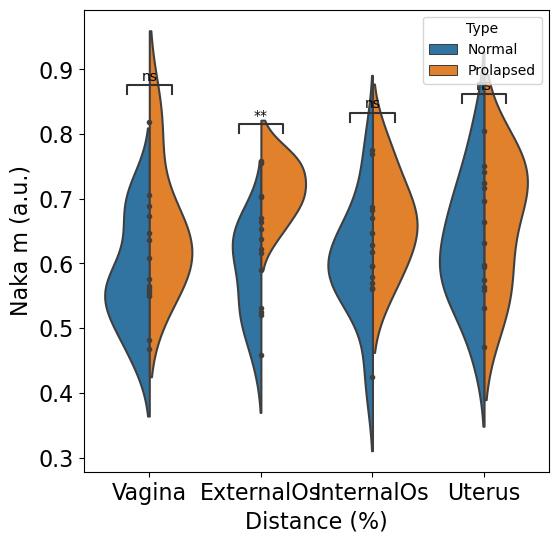

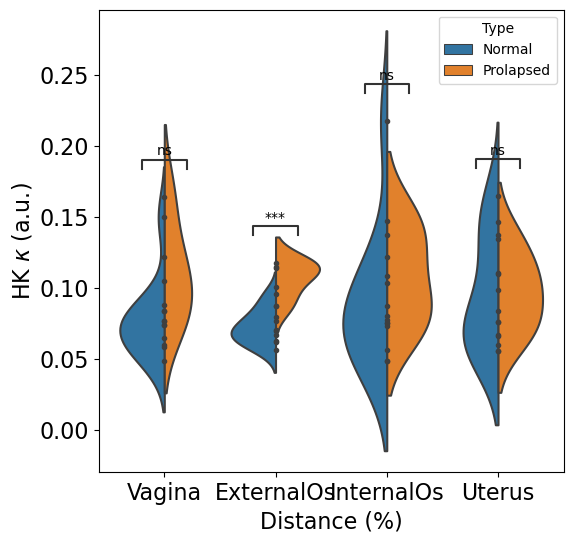

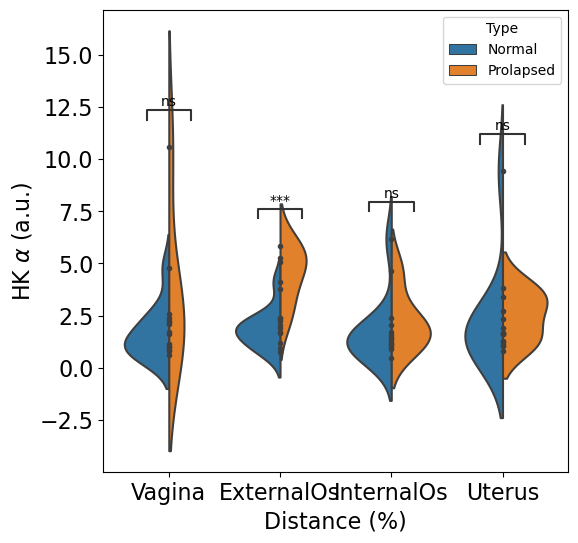

In [5]:
for q_idx, q_param in enumerate(qus_params):
    
    p_values = [None]*len(all_regions)
    for d_idx, dist in enumerate(all_regions):
        p_values[d_idx] =p_df_dist.loc[q_param][dist]

    print(p_values)
    
    this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

    
    hue_plot_params = {'data':in_data,'x':'Organ', 'order':all_regions, 'y': q_param,'hue':'Type','hue_order':all_types}
    violin_plot_params = {'data':in_data,'x':'Organ', 'order':all_regions, 'y': q_param,'hue':'Type','hue_order':all_types,'inner':'point','split':True}
    #hue_scatter = {'data':placenta_avg,'x':'Distance','y': q_param, 'hue':'Type','hue_order':['Normal','Preeclamptic'],'style':'ID'}

    #sns.scatterplot(ax=this_ax,**hue_scatter)
    #sns.boxplot(ax=this_ax,**hue_plot_params)
    sns.violinplot(ax=this_ax,**violin_plot_params)
    annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
    annotator.set_pvalues(p_values)
    annotator.annotate()


    this_ax.set_xlabel('Distance (%)',fontsize=16)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=16)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

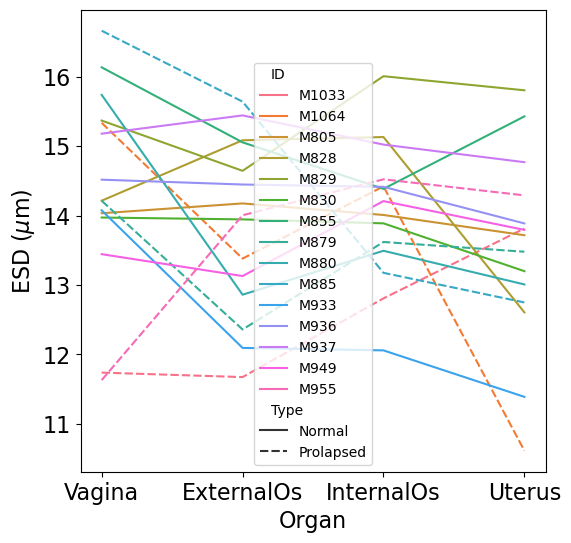

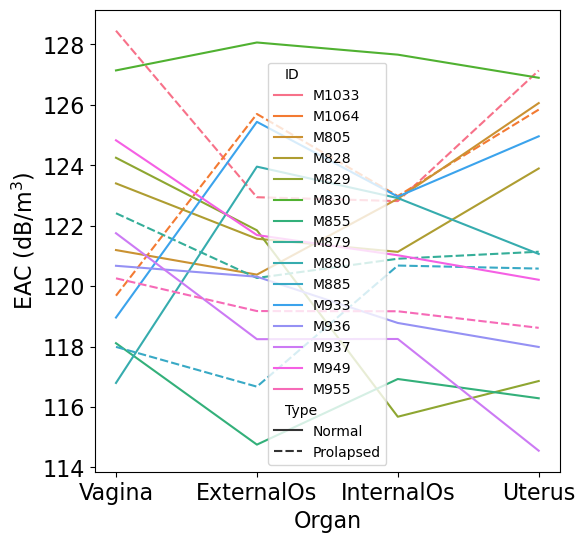

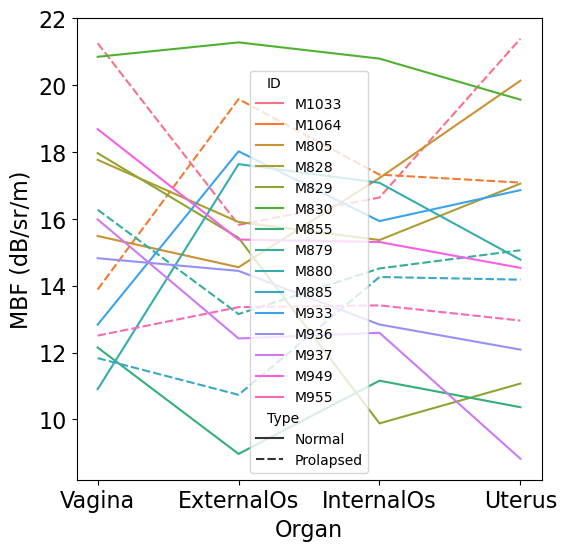

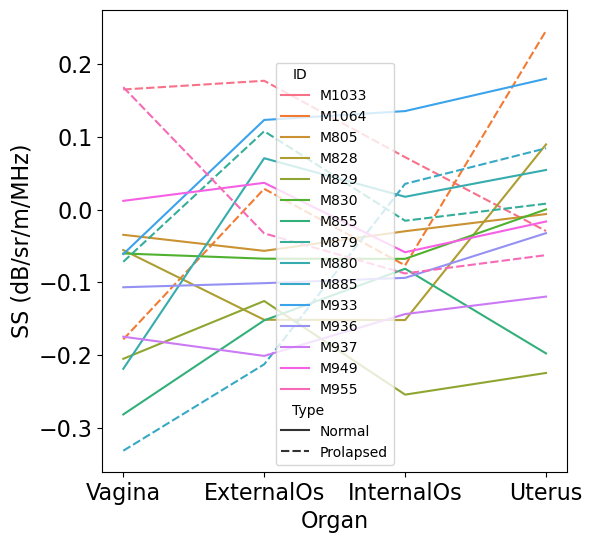

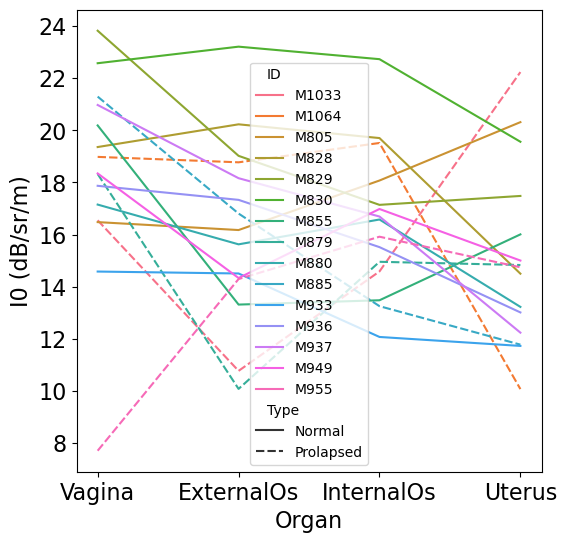

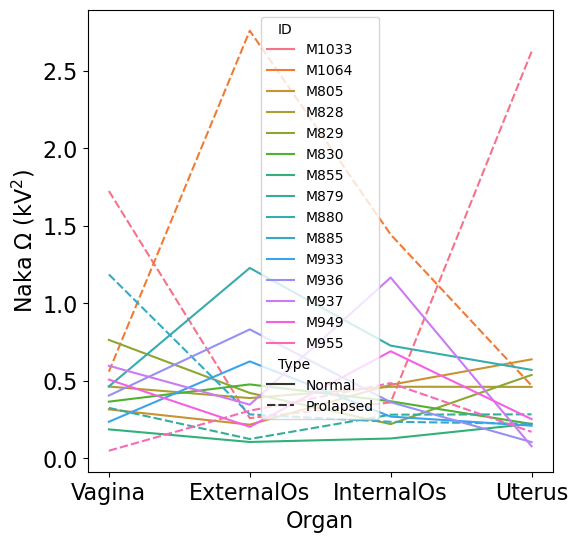

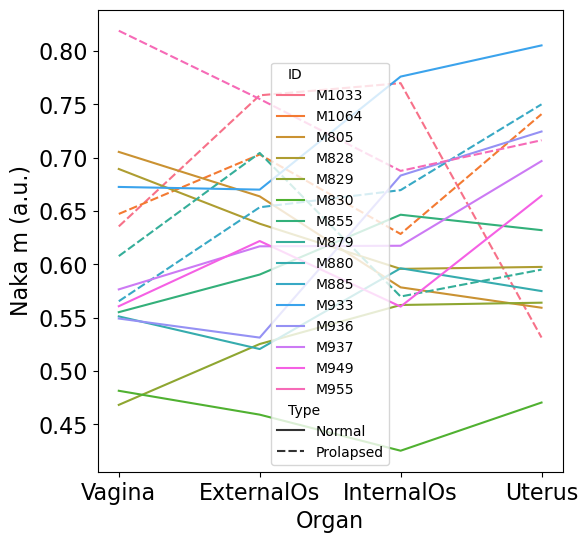

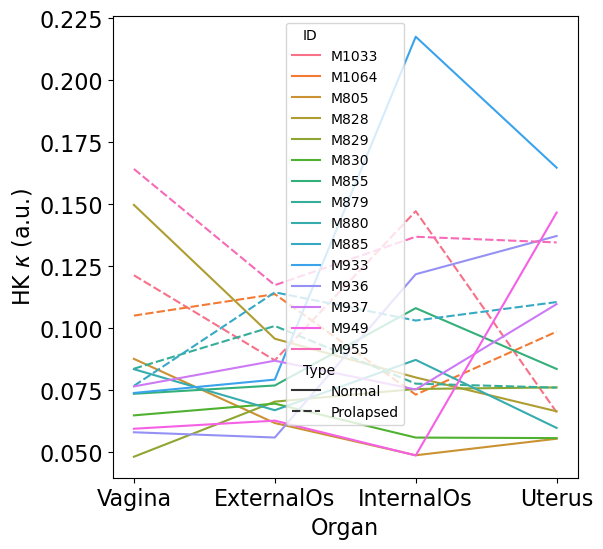

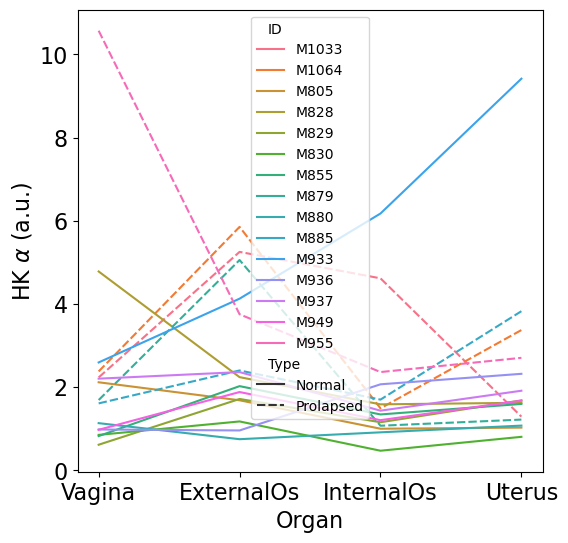

In [6]:
for q_idx, q_param in enumerate(qus_params):
    
    p_values = [None]*len(all_regions)
    for d_idx, dist in enumerate(all_regions):
        p_values[d_idx] =p_df_dist.loc[q_param][dist]

    #print(p_values)
    
    this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

    
    #hue_plot_params = {'data':in_data,'x':'Region','order':all_regions,'y': 'Measurement'}
    hue_plot_params = {'data':in_data,'x':'Organ','y': q_param,'style':'Type','hue':'ID'}
    #hue_scatter = {'data':in_data,'x':'Region', 'order':['Junctional Zone','Labyrinth Zone','Chorionic Plate'],'y': 'Measurement', 'hue':'Type','hue_order':['Normal','Prolapsed'],'style':'ID'}

    #sns.scatterplot(ax=this_ax,**hue_scatter)
    sns.lineplot(ax=this_ax,**hue_plot_params)
    #annotator = Annotator(this_ax,type_comp_pairs,**hue_plot_params)
    #annotator.set_pvalues(p_values)
    #annotator.annotate()


    this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=16)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)


In [7]:
p_mat_d = np.zeros((len(qus_params),6))
diff_mat = np.zeros(p_mat_d.shape)

for d_idx, tp in enumerate(all_types):
    #print(dist)
    sub_df = in_data[in_data['Type'] == tp]
    #print(sub_df)

    for q_idx, param in enumerate(qus_params):
        vag = sub_df[sub_df['Organ'] == 'Vagina'][param]
        ex_os = sub_df[sub_df['Organ'] == 'ExternalOs'][param]
        in_os = sub_df[sub_df['Organ'] == 'InternalOs'][param]
        ute = sub_df[sub_df['Organ'] == 'Uterus'][param]

        #print(vag)

        vag_mean = np.mean(vag)
        ex_os_mean = np.mean(ex_os)
        in_os_mean = np.mean(in_os)
        ute_mean = np.mean(ute)

        this_t, this_p = scipy.stats.ttest_ind(vag.values.reshape(-1,1),ex_os.values.reshape(-1,1))
        p_mat_d[q_idx,d_idx*3] = this_p
        diff_mat[q_idx,d_idx*3] = ex_os_mean - vag_mean

        this_t, this_p = scipy.stats.ttest_ind(in_os.values.reshape(-1,1),ex_os.values.reshape(-1,1))
        p_mat_d[q_idx,d_idx*3+1] = this_p
        diff_mat[q_idx,d_idx*3+1] = ex_os_mean - in_os_mean

        this_t, this_p = scipy.stats.ttest_ind(ute.values.reshape(-1,1),ex_os.values.reshape(-1,1))
        p_mat_d[q_idx,d_idx*3+2] = this_p
        diff_mat[q_idx,d_idx*3+2] = ex_os_mean - ute_mean


p_df_type = pd.DataFrame(p_mat_d,index=qus_params)
diff_df_type = pd.DataFrame(diff_mat,index=qus_params)

p_df_type

C:\Users\amarkel\AppData\Local\Temp\ipykernel_5852\946948026.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,d_idx*3] = this_p
C:\Users\amarkel\AppData\Local\Temp\ipykernel_5852\946948026.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,d_idx*3+1] = this_p
C:\Users\amarkel\AppData\Local\Temp\ipykernel_5852\946948026.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,d_idx*3+2] = this_p


,0,1,2,3,4,5
ESD,0.206652,0.721224,0.553401,0.686859,0.707977,0.665886
EAC,0.957336,0.625753,0.685674,0.744268,0.839291,0.469216
MBF,0.816476,0.693627,0.594077,0.791266,0.686644,0.467355
SS,0.231337,0.830376,0.506607,0.606999,0.713020,0.690772
I0,0.157163,0.830008,0.180611,0.424421,0.471235,0.831722
Naka Omega,0.656441,0.986949,0.229654,0.970834,0.745656,0.991629
Naka m,0.937292,0.582449,0.248553,0.242967,0.230458,0.344149
HK k,0.617753,0.253295,0.107877,0.838345,0.957078,0.499653
HK alpha,0.719489,0.795186,0.628406,0.686635,0.036267,0.041472


In [8]:
all_comp_pairs = [[("ExternalOs","Normal"),("Vagina","Normal")],[("ExternalOs","Normal"),("InternalOs","Normal")],[("ExternalOs","Normal"),("Uterus","Normal")],
              [("ExternalOs","Prolapsed"),("Vagina","Prolapsed")],[("ExternalOs","Prolapsed"),("InternalOs","Prolapsed")],[("ExternalOs","Prolapsed"),("Uterus","Prolapsed")]]

0    0.206652
1    0.721224
2    0.553401
3    0.686859
4    0.707977
5    0.665886
Name: ESD, dtype: float64
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Vagina_Normal vs. ExternalOs_Normal: Custom statistical test, P_val:2.067e-01
ExternalOs_Normal vs. InternalOs_Normal: Custom statistical test, P_val:7.212e-01
Vagina_Prolapsed vs. ExternalOs_Prolapsed: Custom statistical test, P_val:6.869e-01
ExternalOs_Prolapsed vs. InternalOs_Prolapsed: Custom statistical test, P_val:7.080e-01
ExternalOs_Normal vs. Uterus_Normal: Custom statistical test, P_val:5.534e-01
ExternalOs_Prolapsed vs. Uterus_Prolapsed: Custom statistical test, P_val:6.659e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Vagina_Norma

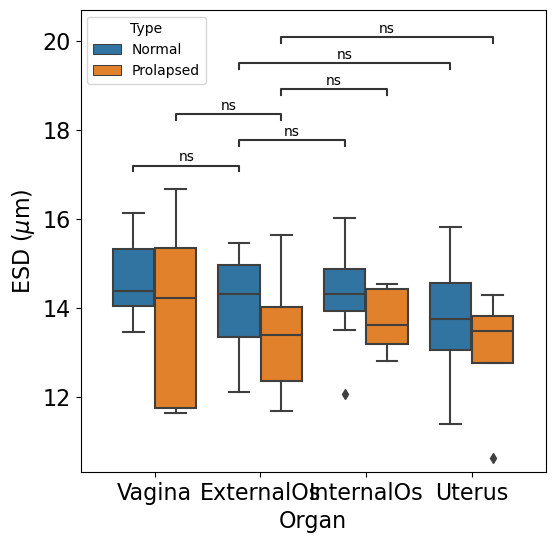

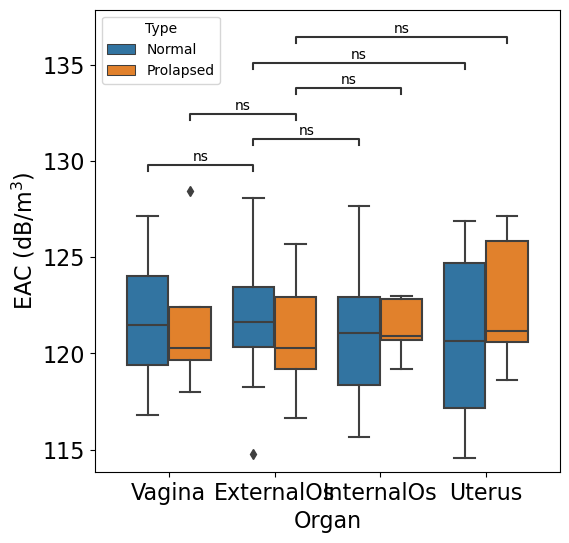

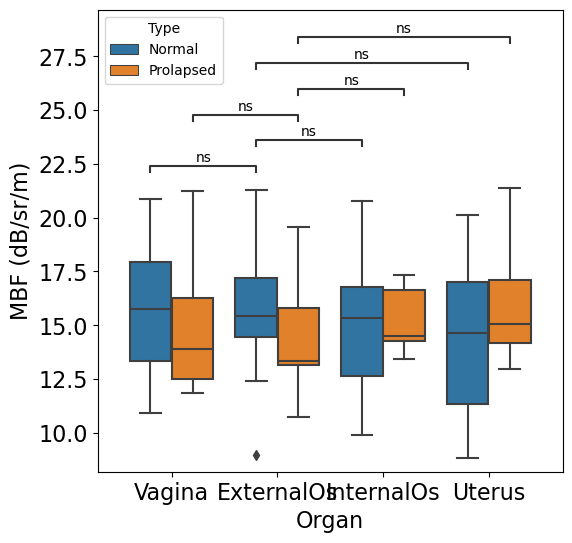

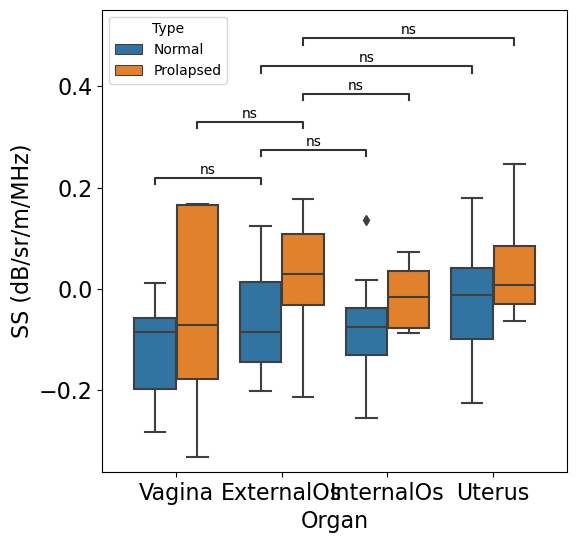

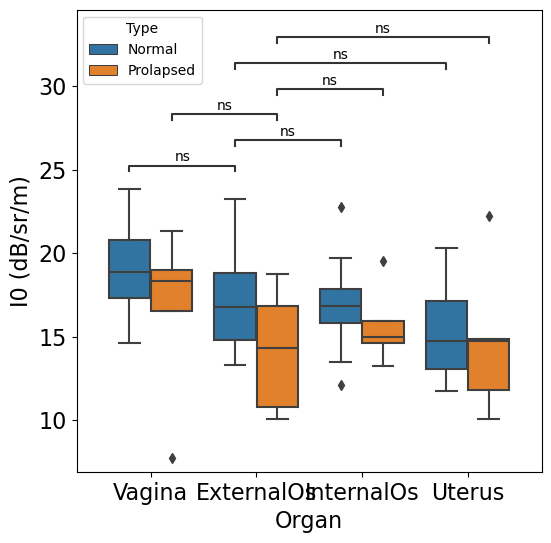

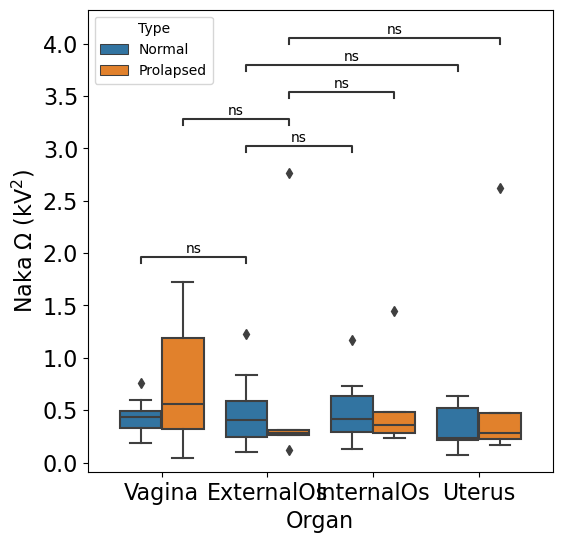

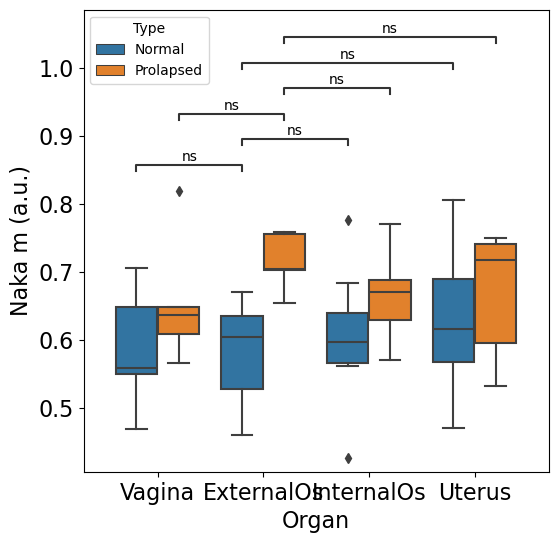

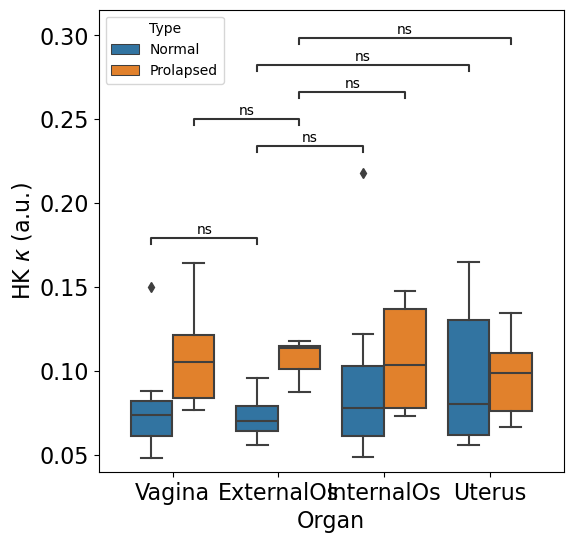

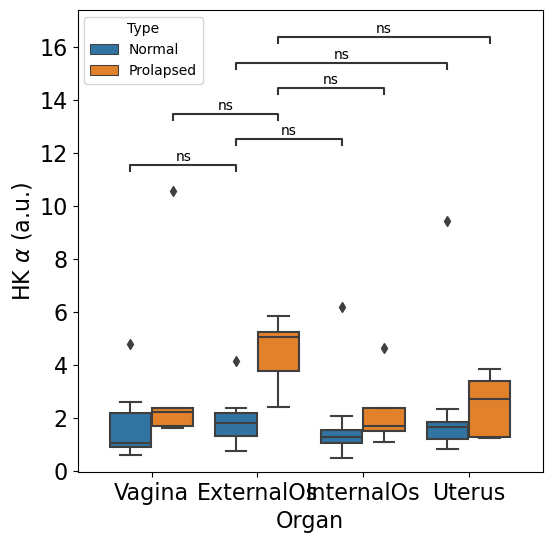

In [9]:
# Plot nucleus size
p_values = p_df_type.iloc[0]
print(p_values)

#print(p_values)
for q_idx, param in enumerate(qus_params):
    this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))


    #hue_plot_params = {'data':in_data,'x':'Region','order':all_regions,'y': 'Measurement'}
    hue_plot_params = {'data':in_data,'x':'Organ','order':all_regions,'y': param,'hue':'Type','hue_order':all_types}
    #hue_scatter = {'data':in_data,'x':'Region', 'order':['Junctional Zone','Labyrinth Zone','Chorionic Plate'],'y': 'Measurement', 'hue':'Type','hue_order':['Normal','Prolapsed'],'style':'ID'}

    #sns.scatterplot(ax=this_ax,**hue_scatter)
    sns.boxplot(ax=this_ax,**hue_plot_params)
    annotator = Annotator(this_ax,all_comp_pairs,**hue_plot_params)
    annotator.set_pvalues(p_values)
    annotator.annotate()

    this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=16)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

In [10]:
#Clean, average, and save correlation data for export to compare with ESD
#for col in corr_data.columns:
#    if col != 'Region' and col != 'Animal' and col != 'Type' and col != 'ESD':
#            corr_data.drop(columns = [col],inplace=True)
#corr_data = corr_data.groupby(['Animal','Type','Region'],as_index=False).mean()
#corr_data
save_dir = r'D:\Andrew\Prolapse Model\correlation_data.csv'
in_data.to_csv(save_dir)

In [11]:
#Load age data to correlate
age_dir = r'C:\Users\amarkel\Box\Imaging Data\3D Cervix\Fibulin 5 model'
age_fid = r'anatomy_frames.csv'

os.chdir(age_dir)
age_data = pd.read_csv(age_fid)

for col in age_data.columns:
    if col != 'ID' and col != 'Organ' and col != 'Type' and col != 'Age' and col != 'Grade':
            age_data.drop(columns = [col],inplace=True)
corr_data = in_data.set_index(['ID']).join(age_data.set_index(['ID']))
print(corr_data)

            Organ       Type      HK k   HK alpha    Naka m  Naka Omega  \
ID                                                                        
M1033  ExternalOs  Prolapsed  0.087129   5.251884  0.758498    0.258916   
M1033  InternalOs  Prolapsed  0.147272   4.616146  0.769903    0.360387   
M1033      Uterus  Prolapsed  0.066164   1.290311  0.531419    2.624892   
M1033      Vagina  Prolapsed  0.121422   2.232462  0.635589    1.725038   
M1064  ExternalOs  Prolapsed  0.113816   5.852787  0.703014    2.759782   
M1064  InternalOs  Prolapsed  0.073286   1.489724  0.628503    1.443915   
M1064      Uterus  Prolapsed  0.098693   3.371933  0.740847    0.468923   
M1064      Vagina  Prolapsed  0.105159   2.377169  0.647281    0.558828   
M805   ExternalOs     Normal  0.061822   1.683270  0.663760    0.216651   
M805   InternalOs     Normal  0.048836   0.999585  0.578464    0.473924   
M805       Uterus     Normal  0.055500   1.026286  0.559348    0.638415   
M805       Vagina     Nor

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\a

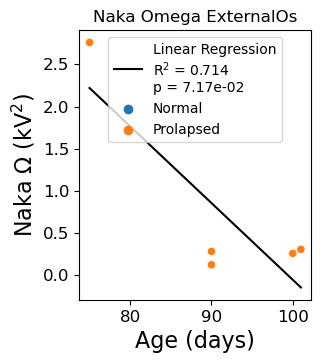

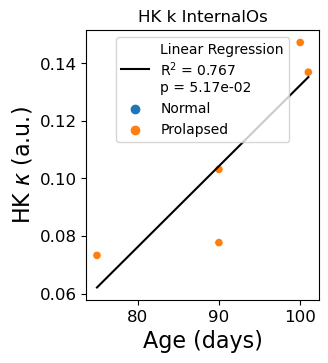

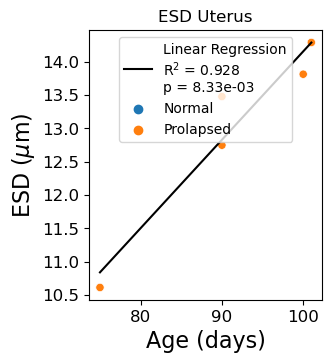

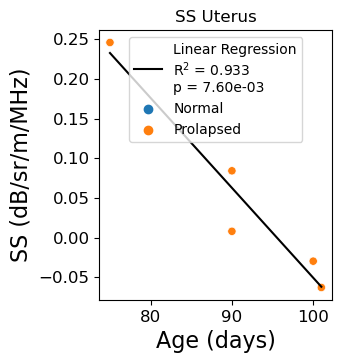

In [20]:
#Compute linear regression for all samples


for t_idx, tp in enumerate(all_types):
    type_data = corr_data[corr_data['Type'] == tp]

    r_mat_d = np.zeros((len(qus_params),len(all_regions)))
    for r_idx, reg in enumerate(all_regions):
        org_data = type_data[type_data['Organ'] == reg] 
        for q_idx, param in enumerate(qus_params):
            x = org_data[['Age']]
            #print(x)
            y = org_data[param]
            #print(y)
            model = LinearRegression()
            res = model.fit(x,y)
            x_pred = np.linspace(x.min(), x.max(), 100)
            y_pred = model.predict(x_pred)
            r2 = model.score(x,y)
            r_mat_d[q_idx,r_idx] = r2
            #print(f"R-squared {r2}")

            x2 = sm.add_constant(x)
            m = sm.OLS(y,x2)
            mfit = m.fit()
            #print(reg)
            #print(mfit.pvalues)

            #Plot the data
            if r2 > 0.7:
                this_fig, this_ax = plt.subplots(1,1,figsize=(3,3.5))
                plt.plot(x_pred,y_pred,color='black',label=f"Linear Regression\nR$^{2}$ = {r2:.3f}\np = {mfit.pvalues[1]:.2e}")
                #plt.plot(xc,yc_pred,color='#1f77b4',label=f"Control (R$^{2}$ = {r2_control:.2f})")
                #plt.plot(xr,yr_pred,color='#ff7f0e',label =f"RUPP (R$^{2}$ = {r2_rupp:.2f})")
                #plt.legend(title = 'Linear Regression')
                #plt.legend(["All","Control", "RUPP"], loc="upper left")
                markers = {"Vagina": "s", "ExternalOs": "X", "InternalOs":"+", "Uterus":"o"}
                sns.scatterplot(data=org_data, x="Age", y=param,hue = 'Type')
                leg = plt.legend(title = '',fontsize = 12)
                #leg._legend_box.align = 'left'
                this_ax.set_xlabel('Age (days)',fontsize=16)
                this_ax.set_ylabel(qus_params_key[q_idx],fontsize=16)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.title(param+" "+reg)
                sns.move_legend(this_ax, "upper center")

    #print(r_mat_d)
    r_df = pd.DataFrame(data = r_mat_d, index = qus_params, columns = all_regions)
    save_name = data_dir + '\\' + tp + '_qus_age_corr.csv'
    r_df.to_csv(save_name)

In [13]:
fix_data = corr_data[corr_data['Age'] > 60]
fix_data = fix_data[fix_data['Age'] < 200]

print(fix_data)
p_mat = np.zeros((len(qus_params),len(all_regions)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, dist in enumerate(all_regions):
    #dist = str(round(dist,1))
    #print(in_data['ESD'])
    sub_df = fix_data[fix_data['Organ'] == dist]
    #print(sub_df)

    for q_idx, param in enumerate(qus_params):
        var_c = sub_df[sub_df['Type'] == 'Normal'][param]
        var_r = sub_df[sub_df['Type'] == 'Prolapsed'][param]

        #print(var_c)
        #print(var_r)

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        var_c_std = np.std(var_c)
        var_r_std = np.std(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        #print(this_p)
        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df_dist = pd.DataFrame(p_mat,index=qus_params,columns=all_regions)
diff_df_dist = pd.DataFrame(diff_mat,index=qus_params,columns=all_regions)

p_df_dist

            Organ       Type      HK k   HK alpha    Naka m  Naka Omega  \
ID                                                                        
M1033  ExternalOs  Prolapsed  0.087129   5.251884  0.758498    0.258916   
M1033  InternalOs  Prolapsed  0.147272   4.616146  0.769903    0.360387   
M1033      Uterus  Prolapsed  0.066164   1.290311  0.531419    2.624892   
M1033      Vagina  Prolapsed  0.121422   2.232462  0.635589    1.725038   
M1064  ExternalOs  Prolapsed  0.113816   5.852787  0.703014    2.759782   
M1064  InternalOs  Prolapsed  0.073286   1.489724  0.628503    1.443915   
M1064      Uterus  Prolapsed  0.098693   3.371933  0.740847    0.468923   
M1064      Vagina  Prolapsed  0.105159   2.377169  0.647281    0.558828   
M855   ExternalOs     Normal  0.076977   2.023516  0.590450    0.104929   
M855   InternalOs     Normal  0.108160   1.343019  0.646547    0.127508   
M855       Uterus     Normal  0.083640   1.595516  0.632080    0.222918   
M855       Vagina     Nor

C:\Users\amarkel\AppData\Local\Temp\ipykernel_5852\2343923477.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat[q_idx,d_idx] = this_p


,Vagina,ExternalOs,InternalOs,Uterus
ESD,0.378230,0.634125,0.701941,0.424127
EAC,0.471510,0.924409,0.397347,0.152762
MBF,0.656798,0.980509,0.404212,0.124688
SS,0.399650,0.562771,0.675496,0.382265
I0,0.509740,0.440466,0.754100,0.568670
Naka Omega,0.224876,0.709291,0.987856,0.264053
Naka m,0.116869,0.003399,0.695103,0.767603
HK k,0.026137,0.000939,0.943562,0.374967
HK alpha,0.192649,0.012113,0.957412,0.739966


[0.3782296006563227, 0.6341247863072393, 0.7019405624498669, 0.4241269302459686]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:6.341e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:3.782e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:7.019e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:4.241e-01
[0.47150985200232653, 0.9244092033904558, 0.39734672566766305, 0.15276243081501115]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:9.244e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:4.715e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:3.973e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:1.528e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


[0.6567978866438106, 0.980508596631543, 0.4042118685133864, 0.12468779783860562]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:9.805e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:6.568e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:4.042e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:1.247e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


[0.3996501310000039, 0.5627709826462856, 0.6754956864608344, 0.38226532855648876]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:5.628e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:3.997e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:6.755e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:3.823e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


[0.5097402797582011, 0.4404661449053723, 0.7540998437115545, 0.568669771556149]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:4.405e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:5.097e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:7.541e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:5.687e-01
[0.22487641464759353, 0.7092912600788934, 0.9878562585454851, 0.2640534692332732]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:7.093e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom st

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:3.399e-03
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:1.169e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:6.951e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:7.676e-01
[0.026137306065496465, 0.0009391689074990632, 0.9435622920472796, 0.3749669382085482]


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:9.392e-04
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:2.614e-02
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:9.436e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:3.750e-01
[0.19264939788702728, 0.012112769060583714, 0.9574117874324723, 0.739965900900101]


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:1.211e-02
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:1.926e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:9.574e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:7.400e-01


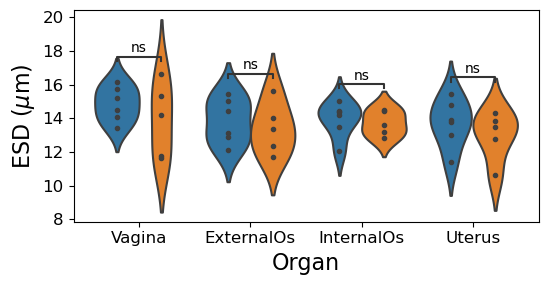

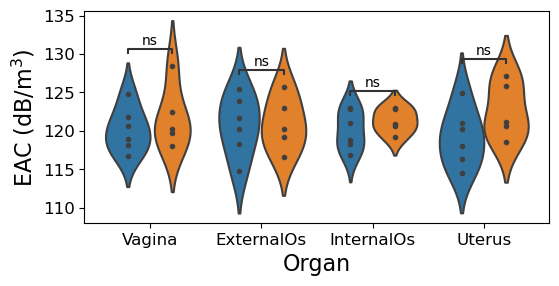

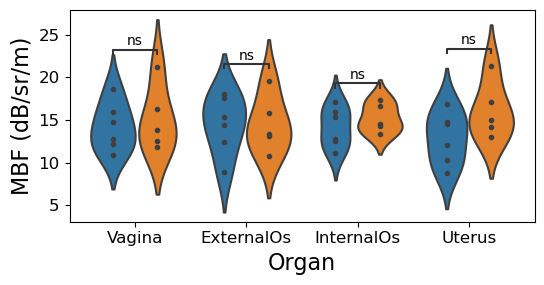

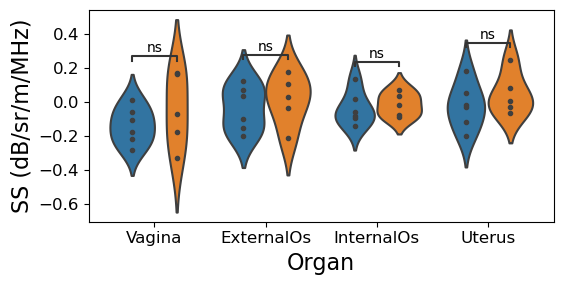

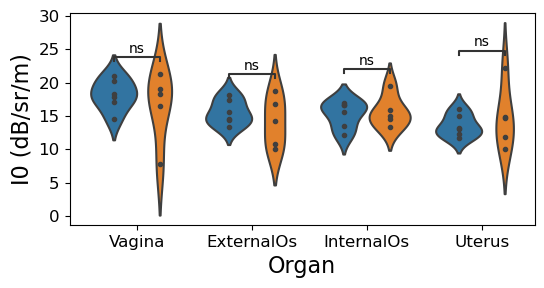

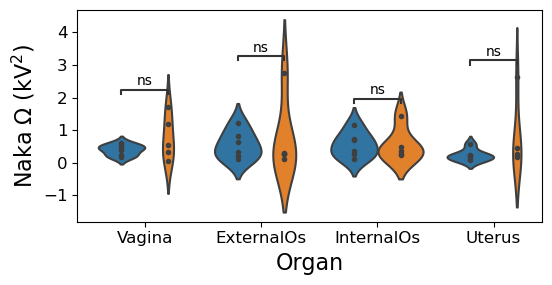

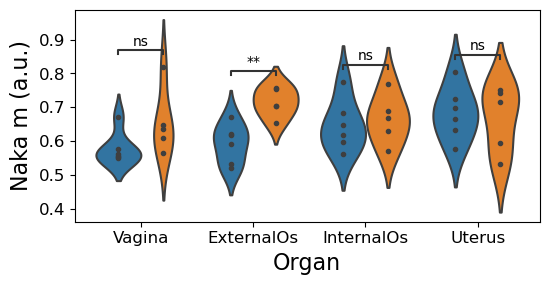

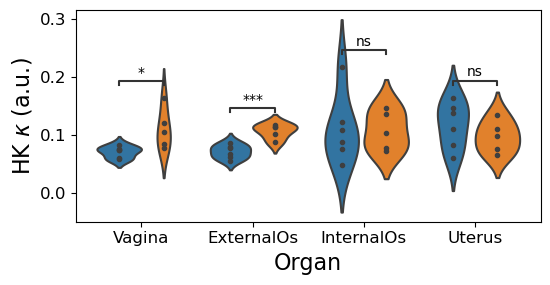

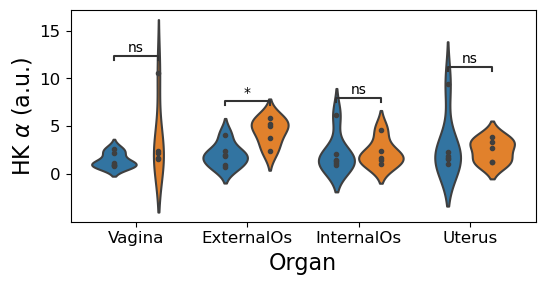

In [14]:
for q_idx, q_param in enumerate(qus_params):
    
    p_values = [None]*len(all_regions)
    for d_idx, dist in enumerate(all_regions):
        p_values[d_idx] =p_df_dist.loc[q_param][dist]

    print(p_values)
    
    this_fig, this_ax = plt.subplots(1,1,figsize=(6,2.75))

    
    hue_plot_params = {'data':fix_data,'x':'Organ', 'order':all_regions, 'y': q_param,'hue':'Type','hue_order':all_types}
    violin_plot_params = {'data':fix_data,'x':'Organ', 'order':all_regions, 'y': q_param,'hue':'Type','hue_order':all_types,'inner':'point','split':False}
    #hue_scatter = {'data':placenta_avg,'x':'Distance','y': q_param, 'hue':'Type','hue_order':['Normal','Preeclamptic'],'style':'ID'}

    #sns.scatterplot(ax=this_ax,**hue_scatter)
    #sns.boxplot(ax=this_ax,**hue_plot_params)
    sns.violinplot(ax=this_ax,**violin_plot_params)
    annotator = Annotator(this_ax,comp_pairs,**hue_plot_params) 
    annotator.set_pvalues(p_values)
    annotator.configure(text_format = 'star')
    annotator.annotate()


    this_ax.set_xlabel('Organ',fontsize=16)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=16)
    this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

[0.3782296006563227, 0.6341247863072393, 0.7019405624498669, 0.4241269302459686]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:6.341e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:3.782e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:7.019e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:4.241e-01
[0.47150985200232653, 0.9244092033904558, 0.39734672566766305, 0.15276243081501115]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:9.244e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:4.715e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:3.973e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:1.528e-01
[0.6567978866438106, 0.980508596631543, 0.4042118685133864, 0.12468779783860562]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:9.805e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:6.568e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:4.042e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:1.247e-01
[0.3996501310000039, 0.5627709826462856, 0.6754956864608344, 0.38226532855648876]


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:5.628e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:3.997e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:6.755e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:3.823e-01
[0.5097402797582011, 0.4404661449053723, 0.7540998437115545, 0.568669771556149]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:4.405e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:5.097e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:5.687e-01
[0.22487641464759353, 0.7092912600788934, 0.9878562585454851, 0.2640534692332732]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:7.093e-01
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:2.249e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:9.879e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:2.641e-01
[0.11686932246424875, 0.0033985023141422347, 0.6951025096547032, 0.7676034225474311]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:3.399e-03


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:1.169e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:6.951e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:7.676e-01
[0.026137306065496465, 0.0009391689074990632, 0.9435622920472796, 0.3749669382085482]


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:9.392e-04
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:2.614e-02
InternalOs_Normal vs. InternalOs_Prolapsed: Custom statistical test, P_val:9.436e-01
Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:3.750e-01
[0.19264939788702728, 0.012112769060583714, 0.9574117874324723, 0.739965900900101]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ExternalOs_Normal vs. ExternalOs_Prolapsed: Custom statistical test, P_val:1.211e-02
Vagina_Normal vs. Vagina_Prolapsed: Custom statistical test, P_val:1.926e-01
InternalOs_Normal vs. InternalOs_Prolapsed: Cus

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


Uterus_Normal vs. Uterus_Prolapsed: Custom statistical test, P_val:7.400e-01


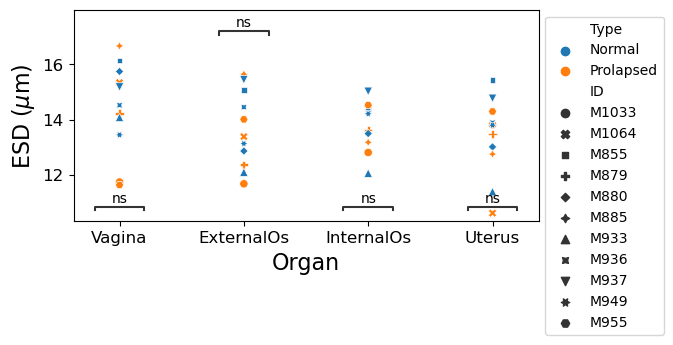

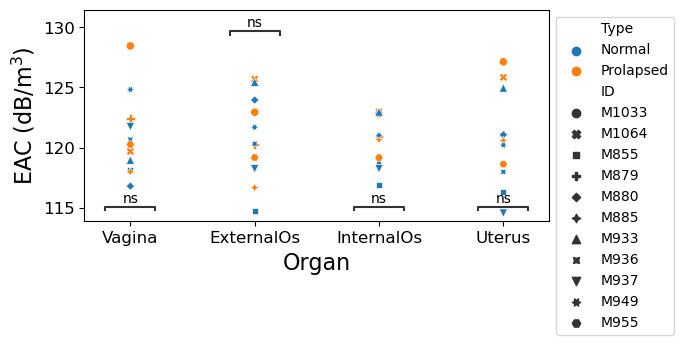

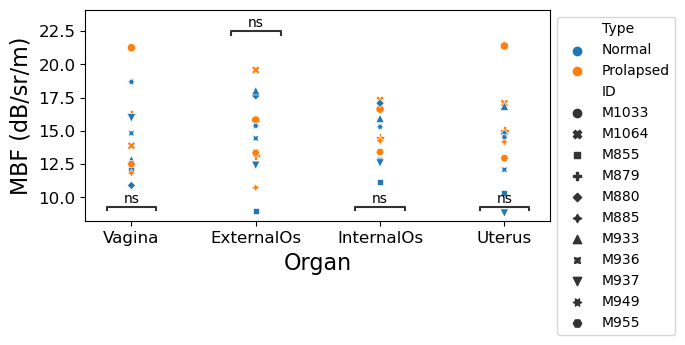

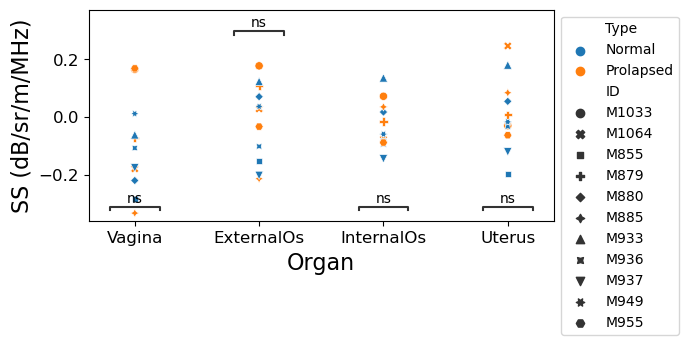

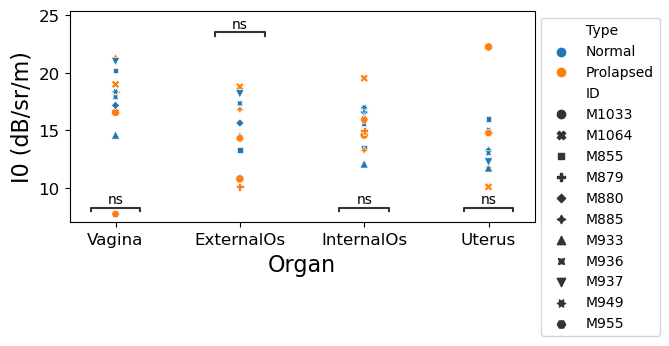

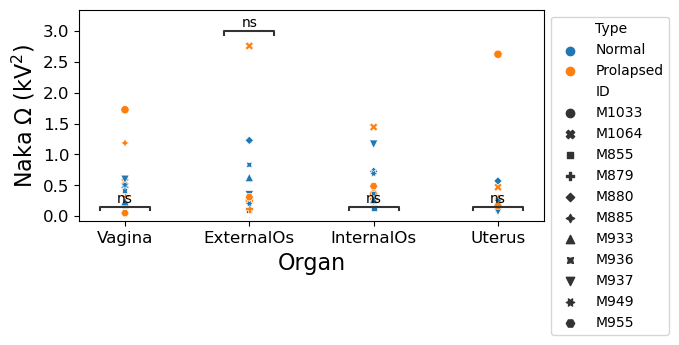

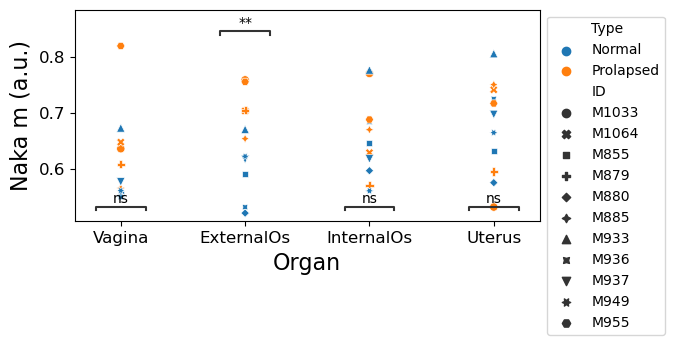

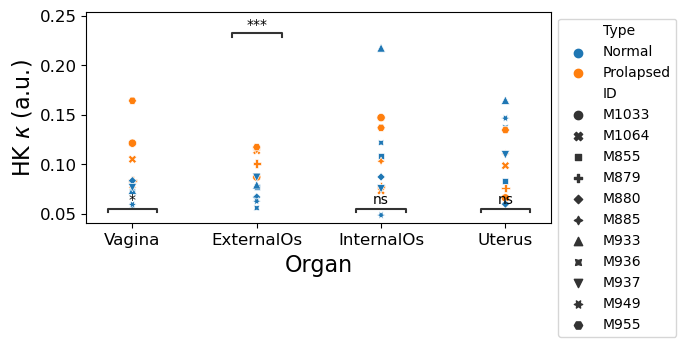

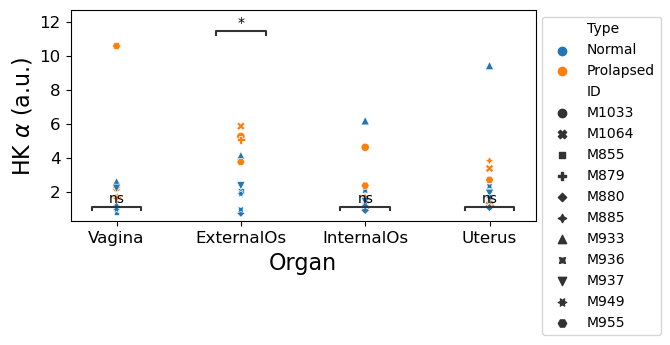

In [25]:
for q_idx, q_param in enumerate(qus_params):
    
    p_values = [None]*len(all_regions)
    for d_idx, dist in enumerate(all_regions):
        p_values[d_idx] =p_df_dist.loc[q_param][dist]

    print(p_values)
    
    this_fig, this_ax = plt.subplots(1,1,figsize=(6,2.75))

    
    #hue_plot_params = {'data':fix_data,'x':'Organ', 'order':all_regions, 'y': q_param,'hue':'Type','hue_order':all_types}
    #violin_plot_params = {'data':fix_data,'x':'Organ', 'order':all_regions, 'y': q_param,'hue':'Type','hue_order':all_types,'inner':'point','split':False}
    hue_scatter = {'data':fix_data,'x':'Organ', 'y': q_param,'hue':'Type','hue_order':all_types,'style':'ID'}

    sns.scatterplot(ax=this_ax,**hue_scatter)
    #sns.boxplot(ax=this_ax,**hue_plot_params)
    #sns.violinplot(ax=this_ax,**violin_plot_params)
    annotator = Annotator(this_ax,comp_pairs,**hue_plot_params) 
    annotator.set_pvalues(p_values)
    annotator.configure(text_format = 'star')
    annotator.annotate()


    this_ax.set_xlabel('Organ',fontsize=16)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=16)
    sns.move_legend(this_ax, "upper left", bbox_to_anchor=(1, 1))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

In [15]:
save_dir = r'D:\Andrew\Prolapse Model\pa_correlation_data.csv'
pa_data = pd.read_csv(save_dir)

uspa_data = pa_data.set_index(['ID','Type','Organ']).join(in_data.set_index(['ID','Type','Organ']))
uspa_data.dropna(axis=0,inplace=True)
#print(uspa_data)

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\a

            R-squared
ESD          0.018779
EAC          0.010065
MBF          0.036930
SS           0.015424
I0           0.064564
Naka Omega   0.000032
Naka m       0.089690
HK k         0.047207
HK alpha     0.148201


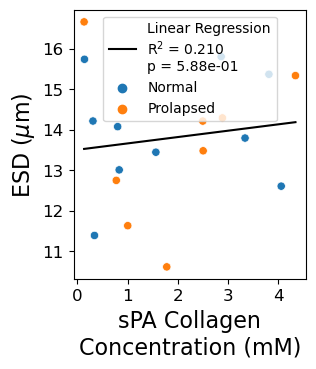

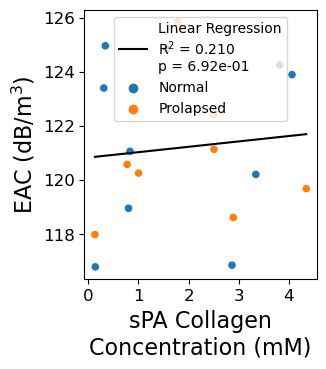

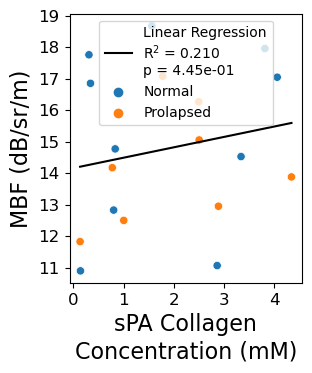

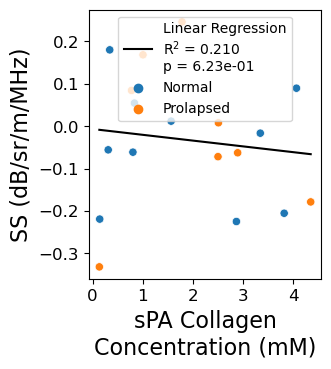

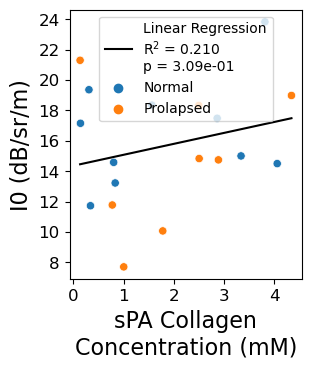

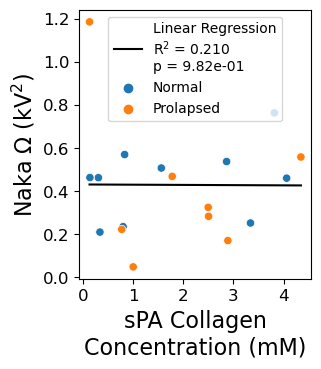

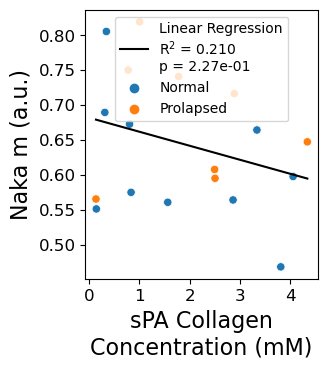

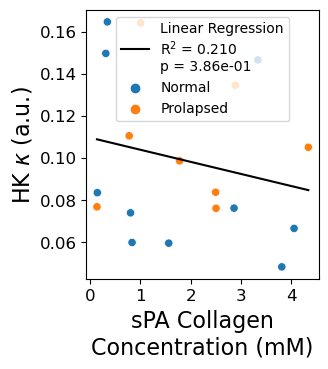

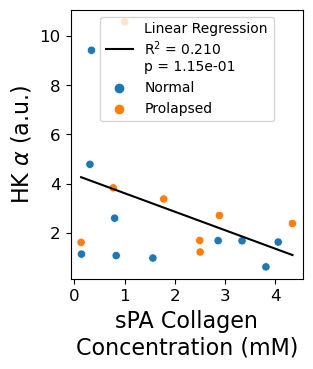

In [16]:
#Compute linear regression for all samples
r_mat_d = np.zeros((len(qus_params),1))

for q_idx, param in enumerate(qus_params):

    x = uspa_data[['Concentration']]
    #print(x)
    y = uspa_data[param]
    #print(y)
    model = LinearRegression()
    res = model.fit(x,y)
    x_pred = np.linspace(x.min(), x.max(), 100)
    y_pred = model.predict(x_pred)
    r2_score = model.score(x,y)
    r_mat_d[q_idx] = r2_score
    #print(f"R-squared {r2_score}")

    x2 = sm.add_constant(x)
    m = sm.OLS(y,x2)
    mfit = m.fit()
    #print(param)
    #print(mfit.pvalues)

    #Plot the data
    this_fig, this_ax = plt.subplots(1,1,figsize=(3,3.5))
    plt.plot(x_pred,y_pred,color='black',label=f"Linear Regression\nR$^{2}$ = {r2:.3f}\np = {mfit.pvalues[1]:.2e}")
    #plt.plot(xc,yc_pred,color='#1f77b4',label=f"Control (R$^{2}$ = {r2_control:.2f})")
    #plt.plot(xr,yr_pred,color='#ff7f0e',label =f"RUPP (R$^{2}$ = {r2_rupp:.2f})")
    #plt.legend(title = 'Linear Regression')
    #plt.legend(["All","Control", "RUPP"], loc="upper left")
    markers = {"Vagina": "s", "ExternalOs": "X", "InternalOs":"+", "Uterus":"o"}
    sns.scatterplot(data=uspa_data, x="Concentration", y=param, hue = 'Type')
    leg = plt.legend(title = '',fontsize = 12)
    #leg._legend_box.align = 'left'
    this_ax.set_xlabel('sPA Collagen\nConcentration (mM)',fontsize=16)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.title(param)
    sns.move_legend(this_ax, "upper center")

#print(r_mat_d)
r_df = pd.DataFrame(data = r_mat_d, index = qus_params, columns = [f"R-squared"])
print(r_df)